In [1]:
import matplotlib.pyplot as plt
import numpy as np

\begin{align}
\ddot{x}(t) + 2\beta\omega_0\dot{x}(t) + \omega_0^2x(t) = 0
\end{align}

Ansatz, $x = \exp(\gamma t)$; $\gamma = -\omega_0\left[\beta \pm i\sqrt{1 - \beta^2}\right]$

In [2]:
def damped_sho(t, omega_0, beta, shift=0):
    # beta less than 1 for underdamped
    envel = beta * omega_0
    osc = np.sqrt(1 - beta**2) * omega_0
    tau = t - shift
    data = np.exp(-envel * tau) * np.cos(osc * tau)
    data[tau < 0] = 0  # assume oscillator starts at tau = 0
    return data

## Plot

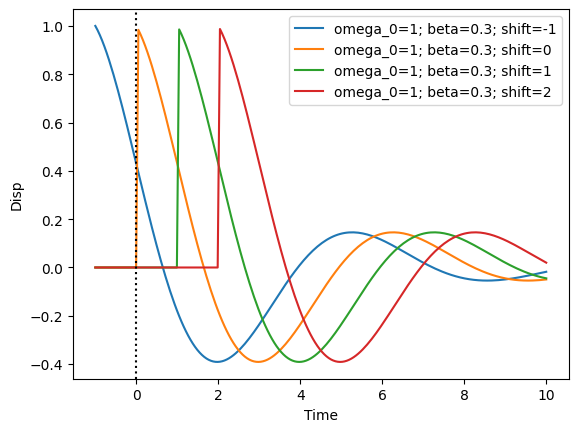

In [3]:
omega_0 = 1
beta = 0.3

t_vals = np.linspace(-1, 10, 200)
for shift in [-1, 0, 1, 2]:
    x_vals = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{omega_0=}; {beta=}; {shift=}")
plt.xlabel("Time")
plt.ylabel("Disp")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()

In [4]:
injection_parameters = dict(omega_0=omega_0, beta=beta, shift=2)

In [5]:
num_points = 200
t_vals = np.linspace(-1, 10, num_points)

In [6]:
sigma = 0.05

In [7]:
data = damped_sho(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

Text(0, 0.5, 'y')

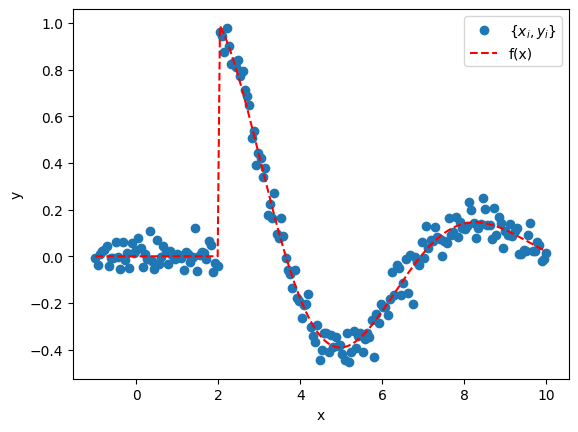

In [8]:
fig, ax = plt.subplots()
ax.plot(t_vals, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(t_vals, damped_sho(t_vals, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [9]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [10]:
priors = dict()

priors['omega_0'] = Uniform(0.1, 2, name='omega_0', latex_label='$\omega_0$')
priors['beta'] = Uniform(0, 0.5, name='beta', latex_label='$\\beta$')
priors['shift'] = Uniform(-4, 4, name='shift', latex_label='$\Delta\;t$')

## Likelihood

In [11]:
# from bilby.core.likelihood import GaussianLikelihood

# log_l = GaussianLikelihood(t_vals, data, damped_sho, sigma=sigma)

In [12]:
# result = bilby.run_sampler(
#     likelihood=log_l, priors=priors, sampler='dynesty',
#     nlive=300, npool=4, save=False, clean=True,
#     injection_parameters=injection_parameters,
#     outdir='./damped_sho',
#     label='damped_sho'
# )

In [13]:
# result.plot_corner(priors=True)

# Train embedding space first

The aim is to make the network be agnostic to shift in time. Train embedding space to cluster shifts in intercept value.

In [14]:
from IPython.display import clear_output
from time import sleep

In [15]:
def get_data(omega_0=None, beta=None, shift=None, num_points=1):
    """Sample omega, beta, shift and return a batch of data with noise"""
    omega_0 = priors['omega_0'].sample() if omega_0 is None else omega_0
    beta = priors['beta'].sample() if beta is None else beta
    shift = priors['shift'].sample() if shift is None else shift
    t_vals = np.linspace(-1, 10, num_points)
    y = damped_sho(t_vals, omega_0=omega_0, beta=beta, shift=shift)
    y += sigma*np.random.normal(size=y.size)

    return t_vals, y, omega_0, beta, shift

# Add augmentation

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [17]:
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    t_vals, y, omega, beta, shift = get_data(num_points=200, shift=0)
    data_vals.append(y)
    theta_vals.append([omega, beta, shift])

In [18]:
theta_vals = np.array(theta_vals)
data_vals = np.array(data_vals)

In [19]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # augment the data to have several shifted intercepts
        theta, data_aug, data_orig = self.augment(idx)

        return (
            torch.from_numpy(theta).to(torch.float32),
            torch.from_numpy(data_aug).to(torch.float32),
            torch.from_numpy(data_orig).to(torch.float32)
        )

    def augment(self, idx):
        repeats = 30  # just a choice, can be different
        omega = theta_vals[idx][0]
        beta = theta_vals[idx][1]
        theta_aug_vals, data_aug_vals, data_orig_vals = [], [], []
        for _ in range(repeats):
            # reproduce every instance with zero shifts
            t_val, y_val_orig, omega_0, beta, shift = get_data(
                omega_0=omega, beta=beta, shift=0,
                num_points=num_points
            )
            data_orig_vals.append(y_val_orig)
            # augment every instance of natural freq and damping with several shifts
            t_val, y_val, omega_0, beta, shift = get_data(
                omega_0=omega, beta=beta, shift=None,
                num_points=num_points
            )
            data_aug_vals.append(y_val)

            theta_aug_vals.append([omega_0, beta, shift])
        return np.array(theta_aug_vals), np.array(data_aug_vals), np.array(data_orig_vals)

In [20]:
dataset = DataGenerator()

Text(0.5, 1.0, 'Augmented sample; Omega_0 = 0.2; Beta = 0.3')

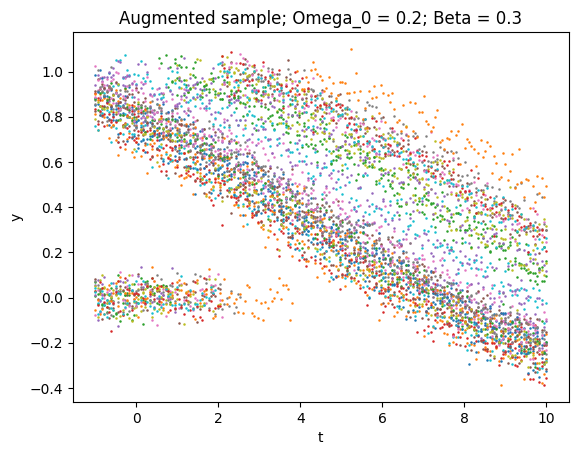

In [21]:
t, d, _ = dataset.augment(4)

fig, ax = plt.subplots()

for (omega, beta, shift), points in zip(t, d):
    ax.plot(t_vals, points, 'o', markersize=0.8, label='$\\{x_i, y_i\\}$')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.set_title(f"Augmented sample; Omega_0 = {t[0][0]:.1f}; Beta = {t[0][1]:.1f}")

In [22]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [23]:
TRAIN_BATCH_SIZE = 200
VAL_BATCH_SIZE = 50

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [24]:
for theta, data_aug, data_orig in train_data_loader:
    break

In [25]:
theta.shape, data_aug.shape, data_orig.shape

(torch.Size([200, 30, 3]),
 torch.Size([200, 30, 200]),
 torch.Size([200, 30, 200]))

# No similarity embedding in MAF

In [26]:
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms import IdentityTransform, NaiveLinear

import nflows.utils as torchutils

In [27]:
num_transforms = 2
num_blocks = 2
hidden_features = 10

# embedding_net = IdentityTransform() # is default; Will increate number of parameters
embedding_net = nn.Linear(200, 2)

context_features = embedding_net(data_aug).shape[-1]

base_dist = StandardNormal([3])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=3,  # 3-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01
        ),
        RandomPermutation(features=3)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist, embedding_net)

In [28]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  1674


In [38]:
flow_model_path = './sho_flow_model_no_similarity_embedding.pt'
# torch.save(flow.state_dict(), flow_model_path)
flow.load_state_dict(torch.load(flow_model_path))

# Train/Validate

In [30]:
num_augmentations = 10

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, augmented_data, orig_data = val
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]
            flow_loss = -flow.log_prob(theta, context=data).mean()

            optimizer.zero_grad()
            flow_loss.backward()
            optimizer.step()
            
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, augmented_data, orig_data = val
        loss = 0
        for ii in range(num_augmentations):
            theta = augmented_theta[:,ii,:]
            data = augmented_data[:,ii,:]

            flow_loss = -flow.log_prob(theta, context=data).mean()
            loss += flow_loss.item()

        running_loss += loss/num_augmentations
        if idx % 10 == 0:
            last_loss = running_loss / 10
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [31]:
optimizer = optim.Adam(flow.parameters(), lr=2e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [32]:
writer = SummaryWriter("sho_flow_no_embedding", comment="With LR=1e-3", flush_secs=5)
epoch_number = 0

In [33]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
EPOCHS = 50

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    # flow._embedding_net.train(False)
    # no gradient tracking for embedding layer
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = False

    avg_train_loss = train_one_epoch(epoch_number, writer)

    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)

    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()

EPOCH 1:
 Avg. train loss/batch after 10 batches = 6.2778
 Avg. train loss/batch after 20 batches = 6.1538
 Avg. train loss/batch after 30 batches = 6.0629
 Avg. train loss/batch after 40 batches = 5.9992
Train/Val flow Loss after epoch: 5.9992/6.0061
EPOCH 2:
 Avg. train loss/batch after 10 batches = 5.9355
 Avg. train loss/batch after 20 batches = 5.8810
 Avg. train loss/batch after 30 batches = 5.8215
 Avg. train loss/batch after 40 batches = 5.7563
Train/Val flow Loss after epoch: 5.7563/5.7354
EPOCH 3:
 Avg. train loss/batch after 10 batches = 5.7104
 Avg. train loss/batch after 20 batches = 5.6411
 Avg. train loss/batch after 30 batches = 5.6144
 Avg. train loss/batch after 40 batches = 5.5665
Train/Val flow Loss after epoch: 5.5665/5.5323
EPOCH 4:
 Avg. train loss/batch after 10 batches = 5.5032
 Avg. train loss/batch after 20 batches = 5.4723
 Avg. train loss/batch after 30 batches = 5.4038
 Avg. train loss/batch after 40 batches = 5.3582
Train/Val flow Loss after epoch: 5.3582

/home/deep/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 10 batches = 5.0337
 Avg. train loss/batch after 20 batches = 4.8676
 Avg. train loss/batch after 30 batches = 4.6878
 Avg. train loss/batch after 40 batches = 4.5133
Train/Val flow Loss after epoch: 4.5133/4.4322
EPOCH 7:
 Avg. train loss/batch after 10 batches = 4.1181
 Avg. train loss/batch after 20 batches = 3.5614
 Avg. train loss/batch after 30 batches = 3.1443
 Avg. train loss/batch after 40 batches = 2.8670
Train/Val flow Loss after epoch: 2.8670/2.7396
EPOCH 8:
 Avg. train loss/batch after 10 batches = 2.6101
 Avg. train loss/batch after 20 batches = 2.4848
 Avg. train loss/batch after 30 batches = 2.4928
 Avg. train loss/batch after 40 batches = 2.4682
Train/Val flow Loss after epoch: 2.4682/2.4498
EPOCH 9:
 Avg. train loss/batch after 10 batches = 2.4551
 Avg. train loss/batch after 20 batches = 2.4213
 Avg. train loss/batch after 30 batches = 2.3289
 Avg. train loss/batch after 40 batches = 2.3111
Train/Val flow Loss after epoch: 2.3111/2.2620
E

 Avg. train loss/batch after 40 batches = 1.5040
Train/Val flow Loss after epoch: 1.5040/1.4199
EPOCH 39:
 Avg. train loss/batch after 10 batches = 1.4621
 Avg. train loss/batch after 20 batches = 1.4970
 Avg. train loss/batch after 30 batches = 1.5366
 Avg. train loss/batch after 40 batches = 1.4538
Train/Val flow Loss after epoch: 1.4538/1.4463
EPOCH 40:
 Avg. train loss/batch after 10 batches = 1.4958
 Avg. train loss/batch after 20 batches = 1.4779
 Avg. train loss/batch after 30 batches = 1.4799
 Avg. train loss/batch after 40 batches = 1.4769
Train/Val flow Loss after epoch: 1.4769/1.4173
EPOCH 41:
 Avg. train loss/batch after 10 batches = 1.4764
 Avg. train loss/batch after 20 batches = 1.5031
 Avg. train loss/batch after 30 batches = 1.5041
 Avg. train loss/batch after 40 batches = 1.4934
Train/Val flow Loss after epoch: 1.4934/1.4654
EPOCH 42:
 Avg. train loss/batch after 10 batches = 1.5001
 Avg. train loss/batch after 20 batches = 1.4659
 Avg. train loss/batch after 30 batch

# Check on test data

In [34]:
import pandas as pd
import corner

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['omega_0'] = float(truth.numpy()[0])
    injections['beta'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['omega_0'] = samples_numpy.T[0].flatten()
    posterior['beta'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

## Posterior

In [35]:
def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["omega_0", "beta", "shift"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

In [36]:
for idx, (theta_test, data_test, data_orig) in enumerate(test_data):
    if idx % 10 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0].reshape((1, 200)))
    live_plot_samples(samples[0], theta_test[0])
    plt.show()

KeyboardInterrupt: 

# PP plot

17:42 bilby INFO    : Key: KS-test p-value
17:42 bilby INFO    : omega_0: 0.5683440710080365
17:42 bilby INFO    : beta: 0.0006256462071240774
17:42 bilby INFO    : Combined p-value: 0.003179529491336238


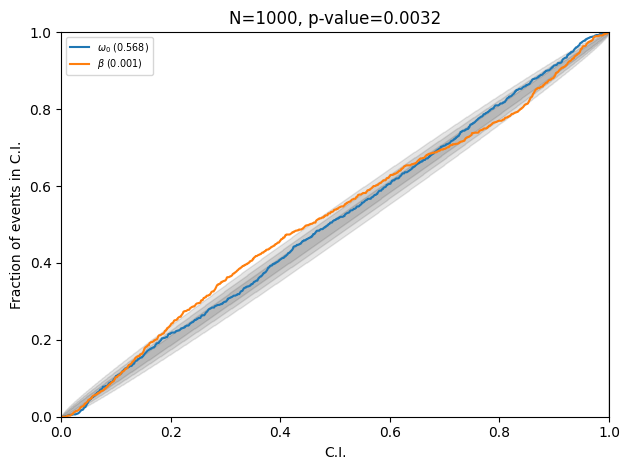

In [37]:
results = []
for idx, (theta_test, data_test, data_unshifted) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0].reshape((1, 200)))
    results.append(
        cast_as_bilby_result(samples, theta_test[0]))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['omega_0', 'beta'])